In [1]:
# This code implements an adversarial network that uses coordinate information and a normalized cross-correlation loss

In [1]:
# conda create -n deepcor python=3.8.17 jupyterlab=4.0.2
# conda activate deepcor
# pip install torch==1.13.1 numpy==1.22.4 nibabel==3.2.1 matplotlib==3.3.2 scipy==1.7.3 scikit-learn==0.24.2 antspyx seaborn==0.11.0 pandas==1.5.3 nilearn==0.7.0
# conda install ipykernel
# python -m ipykernel install --user --name=deepcor --display-name "Python (deepcor)"
# jupyter lab --no-browser --port=xxxx --ip=xxxx # replace Xs with the port and node information
# # click on the Kernel menu and select the appropriate kernel

In [2]:
!date

Thu Mar  6 16:50:36 EST 2025


In [3]:
pwd

'/mmfs1/data/anzellos/projects/deepcor/BC-ABCD-denoise/Code_v2'

### Import libraries

In [22]:
import nibabel as nib
import os
import numpy as np
import matplotlib.pyplot as plt
import nibabel.processing as nibp
from scipy import signal
from itertools import combinations_with_replacement
from numpy import savetxt
import nibabel as nib
import math
from numpy import random
import sklearn.preprocessing  
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from typing import List, Callable, Union, Any, TypeVar, Tuple
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn import linear_model
import sys
from IPython import display
from datetime import datetime
from sklearn.mixture import GaussianMixture
from nilearn.glm.first_level import make_first_level_design_matrix
import pandas as pd
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform, cdist
import ants # ANTSpy in the toolbox for manipulating MRI files 
from tqdm import tqdm # Easy progress bars
import seaborn as sns
import importlib
import pickle

In [5]:
import models
import utils
import datasets
import dashboard

In [25]:
# Run if you updated the libraries
importlib.reload(models)
importlib.reload(utils)
importlib.reload(datasets)
importlib.reload(dashboard)

<module 'dashboard' from '/mmfs1/data/anzellos/projects/deepcor/BC-ABCD-denoise/Code_v2/dashboard.py'>

### Project-specific functions

In [7]:
def get_folders():
        # Specify Data Paths 
    indir = '../Data/StudyForrest/fmriprep/'
    subs_orig = [s for s in os.listdir(indir) if all((s.startswith('sub'),not s.endswith('.html')))]
    n_orig = len(subs_orig)
    epi_fn = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_preproc.nii.gz')
    cf_fn = os.path.join(indir,'mask_roni.nii')
    gm_fn = os.path.join(indir,'mask_roi.nii')
    brain_mask = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz')
    confounds_fname = os.path.join(indir,'{sub}/ses-localizer/func/{sub}_ses-localizer_task-objectcategories_run-{r}_bold_confounds.tsv')
    
    subs = [sub for sub in subs_orig if all(( 
        os.path.exists(epi_fn.format(sub=sub,r=1)),
        os.path.exists(epi_fn.format(sub=sub,r=2)),
        os.path.exists(cf_fn.format(sub=sub)),
        os.path.exists(gm_fn.format(sub=sub)),
        os.path.exists(brain_mask.format(sub=sub,r=1)),
        ))]
    
    subs.sort()
    print(f'{len(subs)}/{len(subs_orig)}')
    return subs,epi_fn,cf_fn,gm_fn,brain_mask,confounds_fname

In [8]:
def prepare_data(epi_fn,cf_fn,gm_fn,brain_mask,confounds_fname,sub,run):
    epi,gm,cf,brain,epi_flat,gm_flat,cf_flat,gm_coords,cf_coords = utils.gather_niftis_coords(sub,epi_fn,cf_fn,gm_fn,brain_mask,run)
    func_gm = epi_flat[gm_flat==1,:] # Data that will be used as the ROI data
    func_cf = epi_flat[cf_flat==1,:] # Data that will be used as the RONI data
    # Train deepcorr with strict ROI and RONI masks. But after that, apply it to the whole brain 
    brain_flat = brain.numpy().flatten()>.5 
    brain_gm = epi_flat[brain_flat,:]
    brain_gm = utils.remove_std0(brain_gm)
    
    # Task regressors
    events_fn = f'../Data/StudyForrest/events/{sub}_ses-localizer_task-objectcategories_run-{run}_events.tsv'
    events = pd.read_csv(events_fn,delimiter='\t')
    t_r = 2.0 
    n_scans = epi_flat.shape[1]  # the acquisition comprises 128 scans
    frame_times = (np.arange(n_scans) * t_r)
    design_matrix = make_first_level_design_matrix(frame_times,events,drift_model="polynomial",drift_order=3,hrf_model="SPM") #
    face_reg = design_matrix[['face','body']].values.sum(axis=1)
    place_reg = design_matrix[['house', 'object', 'scene', 'scramble']].values.sum(axis=1)
    
    ffa_im = ants.image_read(f'../Data/StudyForrest/ROIs/rFFA_final_mask_{sub}_bin.nii.gz')
    func_ffa = func_gm[ffa_im.numpy().flatten()[gm_flat==1]==1,:]
    ffa_scaler = utils.Scaler(func_ffa)
    ffa_list = ffa_scaler.transform(func_ffa)
    ffa_coords = torch.from_numpy(gm_coords[ffa_im.numpy().flatten()[gm_flat==1]==1,:])

    # Confounds
    confounds = utils.gather_confounds(sub,run,confounds_fname)
    
    #Normalization of Data, remove voxels with std of 0 so it doesnt crash CVAE (from Yu Zhu's code)
    func_gm, gm_coords = utils.remove_std0_coords(func_gm,gm_coords)
    # func_gm = utils.remove_std0(func_gm)
    func_cf = utils.remove_std0(func_cf)

    # Apply scaler to ROI and RONI
    obs_scale = utils.Scaler(func_gm)
    obs_list = obs_scale.transform(func_gm)    
    noi_scale = utils.Scaler(func_cf)
    noi_list = noi_scale.transform(func_cf)

    
    return obs_list,noi_list,gm_coords,ffa_list,ffa_coords,face_reg,place_reg, confounds


In [9]:
def initialize_model_motion(sub,run,obs_list,noi_list,gm_coords,confounds):
    torch.cuda.empty_cache()
    torch.cuda.init()
    # Dataset
    train_inputs = datasets.TrainDataset_coords2conv_motion2(obs_list,noi_list,gm_coords,confounds)    
    # Dataloader
    batch_size = 1024
    train_in = torch.utils.data.DataLoader(train_inputs, batch_size=batch_size,shuffle=True, num_workers=1,drop_last=True)
    # Model
    model = models.Conv1Ddenoise_motion2(input_channels = 4)   # need to add the last layer to rebuild the original size
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)  
    # Optimizer
    optimizer = optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    return train_in, model, optimizer

In [10]:
def train(trainloader,model,optimizer,subject,run):
    
    timestamp = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
    conv_dir = f'conv-{sub}-R{run}-T-{timestamp}' # pretraining dir is {sub}-{run}-{timestamp}
    print(conv_dir)
    utils.safe_mkdir(os.path.join('../Data/StudyForrest/conv_coords',conv_dir)) # Makes the directory
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  
    
    n_epochs = 500
    track = {}
    loss_L = []
    loss_signal_L = []
    loss_noise_L = []
    loss_confounds_L = []
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        dataloader_iter_in = iter(train_in)
        running_loss = 0
        running_loss_signal = 0
        running_loss_noise = 0
        running_loss_confounds = 0
        for i in range(len(train_in)):           
            optimizer.zero_grad()
            inputs_gm,inputs_cf,confounds,coords = next(dataloader_iter_in)
            inputs_gm = inputs_gm.float().to(device)
            inputs_cf = inputs_cf.float().to(device)
            confounds = confounds.float().to(device)
            coords = coords.float().to(device)
            [sig, noise, confounds_pred] = model.forward(inputs_gm)
            #loss,loss_signal,loss_noise = model.loss_ncc_gmm(inputs_gm,inputs_cf,signal,noise,pca,gmm,device)
            loss_ncc,loss_signal_ncc,loss_noise_ncc,loss_confounds_ncc = model.loss_ncc(inputs_gm[:,0,:],inputs_cf,sig[:,0:156],noise[:,0:156],confounds[:,:,0:156],confounds_pred[:,:,0:156])
            loss_mse,loss_signal_mse,loss_noise_mse,loss_confounds_mse = model.loss_function(inputs_gm[:,0,:],inputs_cf,sig[:,0:156],noise[:,0:156],confounds[:,:,0:156],confounds_pred[:,:,0:156])
#            print(loss_ncc,loss_signal_ncc,loss_noise_ncc)
#            print(loss_mse,loss_signal_mse,loss_noise_mse)
            loss = loss_ncc+loss_mse
            loss_signal = loss_signal_ncc+loss_signal_mse
            loss_noise = loss_noise_ncc+loss_noise_mse
            loss_confounds = loss_confounds_ncc+loss_confounds_mse
            if np.isnan(loss.detach().cpu().numpy()):
                print('loss is NaN')
                break
            loss.backward()
            optimizer.step()
            running_loss += loss
            running_loss_signal += loss_signal
            running_loss_noise += loss_noise   
            running_loss_confounds += loss_confounds
        epoch_loss = running_loss / len(train_in)
        epoch_loss_signal = running_loss_signal / len(train_in)
        epoch_loss_noise = running_loss_noise / len(train_in)
        epoch_loss_confounds = running_loss_confounds / len(train_in)
        if epoch%50==0:
            print('epoch '+str(epoch)+' loss: '+str(epoch_loss.detach()))
        loss_L.append(epoch_loss.detach().cpu().numpy())
        loss_signal_L.append(epoch_loss_signal.detach().cpu().numpy())
        loss_noise_L.append(epoch_loss_noise.detach().cpu().numpy())
        loss_confounds_L.append(epoch_loss_confounds.detach().cpu().numpy())
        track['loss_L'] = loss_L
        track['loss_signal_L'] = loss_signal_L
        track['loss_noise_L'] = loss_noise_L
        track['loss_confounds_L'] = loss_confounds_L

    torch.save(model.state_dict(),f'../Data/StudyForrest/conv_coords/{conv_dir}/conv_denoise_2-{sub}.weights')
    return model, track

## One subject

### Loading the subject specific data

In [11]:
subject = 1
run = 1

In [12]:
subs,epi_fn,cf_fn,gm_fn,brain_mask,confounds_fname = get_folders()

14/14


In [13]:
sub = subs[int(subject)]

In [14]:
obs_list,noi_list,gm_coords,ffa_list,ffa_coords,face_reg,place_reg, confounds = prepare_data(epi_fn,cf_fn,gm_fn,brain_mask,confounds_fname,sub,run)

### Training the network

In [15]:
n_models = 10
all_models = []
all_tracks = []
for i in range(n_models):
    train_in, model, optimizer = initialize_model_motion(sub,run,obs_list,noi_list,gm_coords,confounds)
    model, track = train(train_in,model,optimizer,subject,run)
    all_models.append(model)
    all_tracks.append(track)

conv-sub-02-R1-T-2025_03_06_16_50_45
epoch 0 loss: tensor(2.6950, device='cuda:0')
epoch 50 loss: tensor(1.7728, device='cuda:0')
epoch 100 loss: tensor(1.7457, device='cuda:0')
epoch 150 loss: tensor(2.3601, device='cuda:0')
epoch 200 loss: tensor(1.8502, device='cuda:0')
epoch 250 loss: tensor(1.8626, device='cuda:0')
epoch 300 loss: tensor(1.7949, device='cuda:0')
epoch 350 loss: tensor(1.8131, device='cuda:0')
epoch 400 loss: tensor(1.8112, device='cuda:0')
epoch 450 loss: tensor(1.7969, device='cuda:0')
conv-sub-02-R1-T-2025_03_06_16_59_30
epoch 0 loss: tensor(2.7446, device='cuda:0')
epoch 50 loss: tensor(2.3912, device='cuda:0')
epoch 100 loss: tensor(2.6973, device='cuda:0')
epoch 150 loss: tensor(2.6973, device='cuda:0')
epoch 200 loss: tensor(2.6964, device='cuda:0')
epoch 250 loss: tensor(2.6973, device='cuda:0')
epoch 300 loss: tensor(2.6958, device='cuda:0')
epoch 350 loss: tensor(2.6970, device='cuda:0')
epoch 400 loss: tensor(2.6973, device='cuda:0')
epoch 450 loss: tens

In [26]:
batch_size = 1024
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
denoised_signal = utils.stable_estimate(ffa_list,batch_size,device,all_models,noi_list,face_reg,place_reg,ffa_coords)

In [27]:
c = np.corrcoef(denoised_signal,face_reg)[0,1]

In [28]:
print(c)

0.6634263665659297


In [17]:
# Save to pickle file
with open('denoisingConfounds_10models_20250306_2.pkl', 'wb') as f:  # 'wb' means write binary mode
    pickle.dump(all_models, f)  # Save the dictionary
    pickle.dump(all_tracks, f)  # Save another variable

In [8]:
# Load from pickle file
with open('denoisingConfounds_10models_20250306.pkl', 'rb') as f:  # 'rb' means read binary mode
    all_models = pickle.load(f)  # First variable
    all_tracks = pickle.load(f)  # Second variable

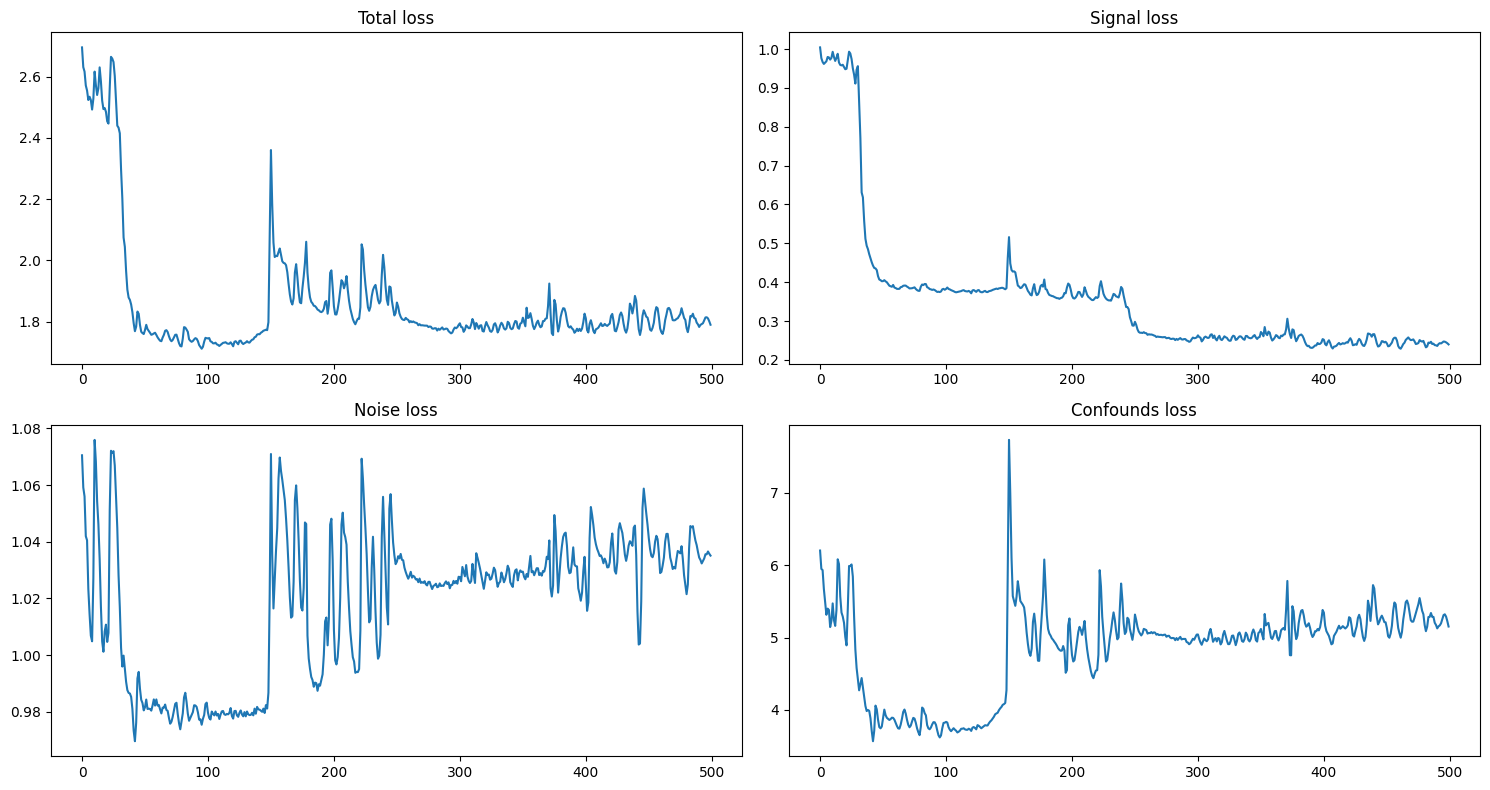

In [42]:
dashboard.adversarial_losses_confounds(all_tracks[0])

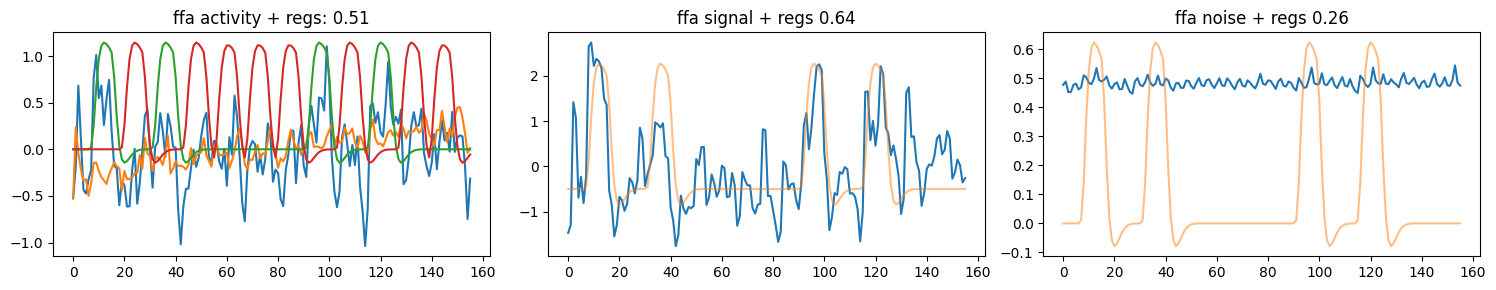

In [41]:
dashboard.adversarial_ffa_motion2(ffa_list,batch_size,device,all_models[0],noi_list,face_reg,place_reg,ffa_coords)

In [30]:
ffa_batch = ffa_list[0:batch_size,:]
ffa_batch = torch.tensor(ffa_batch[:,:]).to(device)
ffa_tensor = ffa_batch.unsqueeze(1)
coords_tensor = ffa_coords.unsqueeze(2)
coords_tensor = coords_tensor.repeat(1,1,ffa_tensor.shape[2])
observation = torch.cat((ffa_tensor,coords_tensor.to(device)),axis=1)
all_corr = []
all_signals = []
for model in all_models:
    signal,noise,confounds_pred = model.forward(observation.to(device))
    signal = signal.detach().cpu().numpy()[:,:156]
    all_signals.append(signal)
    c = np.corrcoef(signal[:,:].mean(axis=0),face_reg)[0,1]
    all_corr.append(c)

In [29]:
print(all_corr)

[0.29082063652913054, 0.5179349758178771, 0.6295955845495047, 0.6422646032993377, 0.5207089354006296, 0.48946471769818095, 0.6118814704595062, 0.5596286005091224, 0.5792655952491589, 0.5136960435978528]


In [41]:
signals_np = np.mean(np.asarray(all_signals),axis=1)

In [47]:
mean_signal = np.mean(signals_np,axis=0)

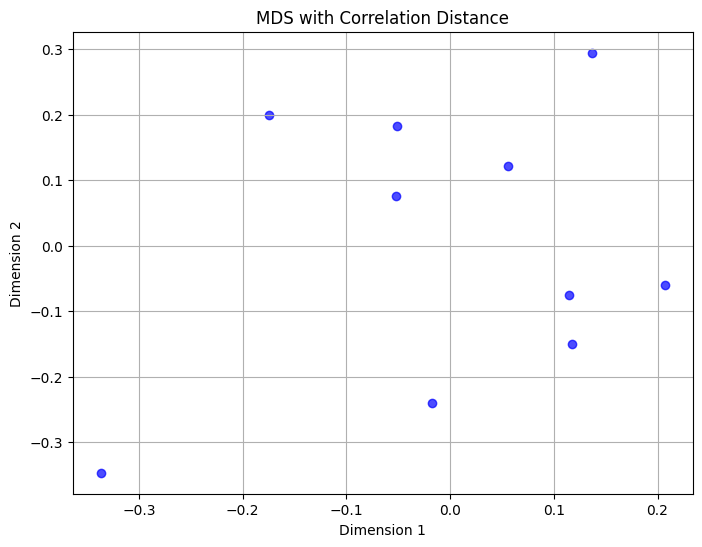

In [46]:
# Step 1: Compute Correlation Distance Matrix
# pdist computes pairwise distances → 'correlation' gives (1 - Pearson correlation)
corr_dist = pdist(signals_np, metric='correlation')
corr_matrix = squareform(corr_dist)  # Convert to square matrix form

# Step 2: Apply MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
vectors_2d = mds.fit_transform(corr_matrix)

# Step 3: Plot
plt.figure(figsize=(8, 6))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='blue', alpha=0.7)
plt.title('MDS with Correlation Distance')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

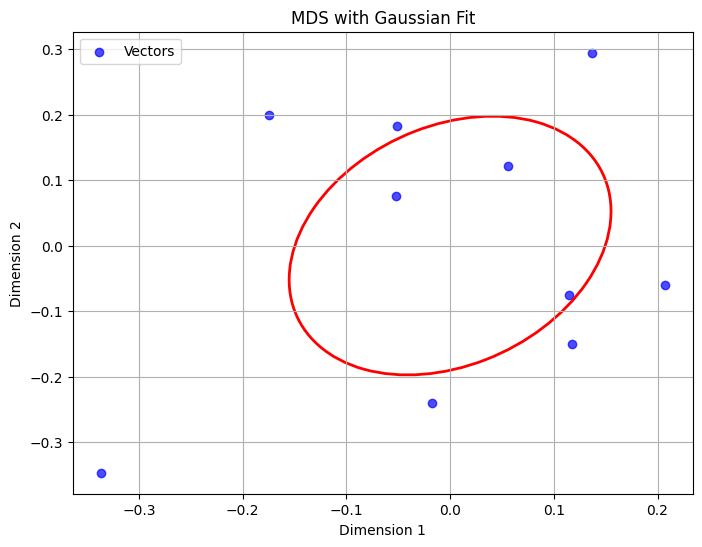

In [49]:
# 3. Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
gmm.fit(vectors_2d)

# 4. Plot the Data + Gaussian
plt.figure(figsize=(8, 6))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='blue', alpha=0.7, label='Vectors')

# Plot Gaussian Ellipse
from matplotlib.patches import Ellipse
def plot_ellipse(gmm, ax):
    mean = gmm.means_[0]
    cov = gmm.covariances_[0]
    eigvals, eigvecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigvals)  # 2 std deviations

    ellipse = Ellipse(mean, width, height, angle=angle, edgecolor='red', facecolor='none', linewidth=2)
    ax.add_patch(ellipse)

ax = plt.gca()
plot_ellipse(gmm, ax)

plt.title("MDS with Gaussian Fit")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.show()


In [50]:
# Get the mean (center of Gaussian)
mean = gmm.means_[0]
print("Mean of Gaussian:", mean)

Mean of Gaussian: [-2.77555756e-18 -1.38777878e-17]


In [54]:
mean_2d = gmm.means_[0]
print("Mean in 2D:", mean_2d)

# 5. Find Nearest Neighbors (Points closest to the Gaussian mean in 2D)
distances = cdist([mean_2d], vectors_2d, metric='euclidean')
nearest_idx = np.argsort(distances[0])[:10]  # Take the 10 closest points

# 6. Approximate High-Dimensional Mean as Weighted Average
weights = np.exp(-distances[0, nearest_idx])  # Closer points get higher weights
weights /= np.sum(weights)
mean_high_dim = np.sum(signals_np[nearest_idx] * weights[:, np.newaxis], axis=0)

Mean in 2D: [-2.77555756e-18 -1.38777878e-17]


In [55]:
c = np.corrcoef(mean_high_dim,face_reg)[0,1]

In [56]:
print(c)

0.6499143823525303


In [ ]:
track['loss_noise_L']

In [87]:
for i in range(10):
    ratio = (all_tracks[i]['loss_noise_L'][-1]+all_tracks[i]['loss_confounds_L'][-1])/all_tracks[i]['loss_signal_L'][-1]
    print(ratio)

44.974163
22.689392
20.934729
16.168268
19.806168
47.248684
26.511156
14.841955
18.739632
12.267175


In [49]:
train_in, model, optimizer = initialize_model_motion(sub,run,obs_list,noi_list,gm_coords,confounds)

In [51]:
model, track = train(train_in,model,optimizer,subject,run)

conv-sub-02-R1-T-2025_03_06_12_19_33
epoch 0 loss: tensor(2.6526, device='cuda:0')


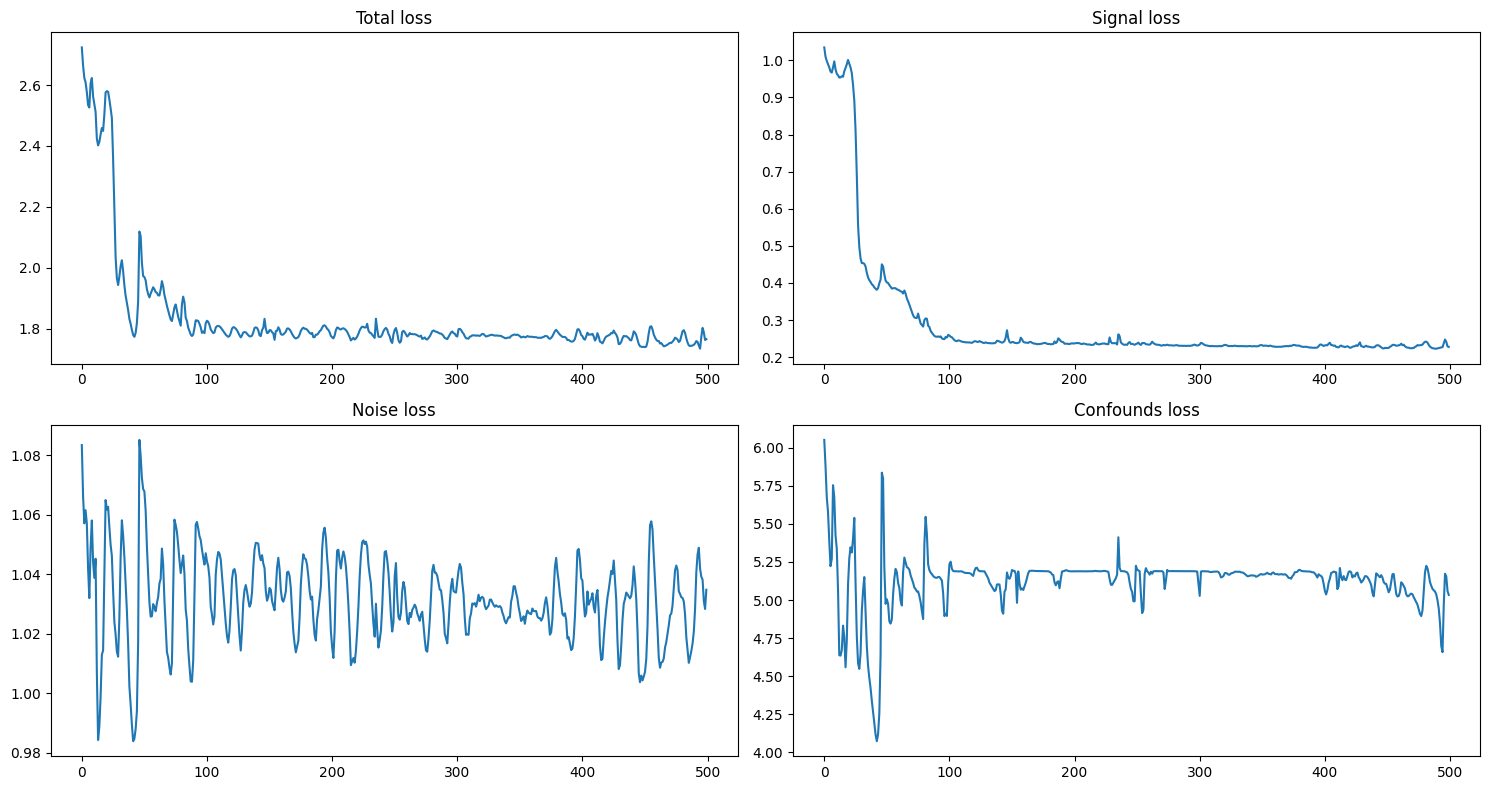

In [41]:
dashboard.adversarial_losses_confounds(track)

In [25]:
batch_size = 1024
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  

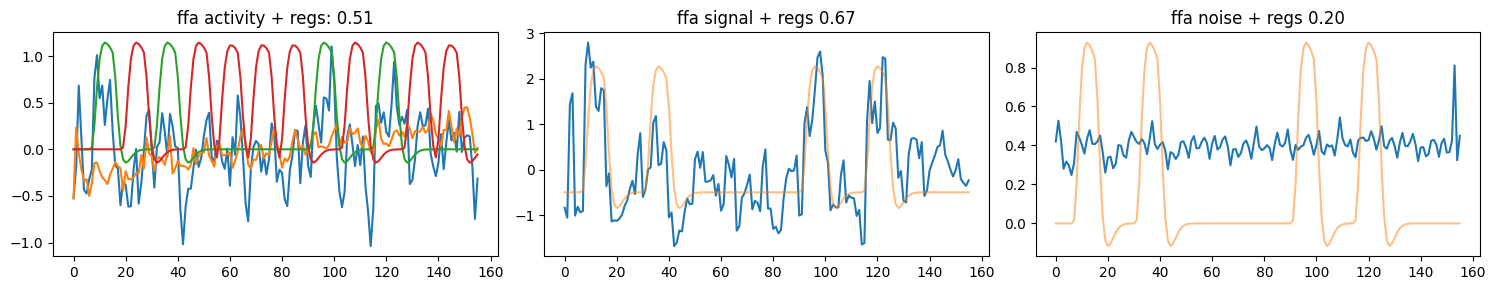

In [43]:
dashboard.adversarial_ffa_motion2(ffa_list,batch_size,device,model,noi_list,face_reg,place_reg,ffa_coords)

In [46]:
(track['loss_noise_L'][-1]+track['loss_confounds_L'][-1])/track['loss_signal_L'][-1]

26.656582

## Multi subject

In [15]:
subs,epi_fn,cf_fn,gm_fn,brain_mask = get_folders()

14/14


In [ ]:
batch_size = 1024
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
all_models = []
corr_raw = []
corr_sig = []
for sub in subs[0:2]:
    models_sub = []
    corr_raw_sub = []
    corr_sig_sub = []
    for r in range(4):
        run = r+1
        obs_list,noi_list,gm_coords,ffa_list,ffa_coords,face_reg,place_reg = prepare_data(epi_fn,cf_fn,gm_fn,brain_mask,sub,run)
        train_in, model_run, optimizer = initialize_model(sub,run,obs_list,noi_list,gm_coords)
        model_run, track = train(train_in,model_run,optimizer,sub,run)
        corr_raw_run, corr_sig_run = utils.calculate_correlations(ffa_list,batch_size,device,model_run,noi_list,face_reg,place_reg,ffa_coords)
        models_sub.append(model_run)
        corr_raw_sub.append(corr_raw_run)
        corr_sig_sub.append(corr_sig_run)
    corr_raw.append(corr_raw_sub)
    corr_sig.append(corr_sig_sub)
    

conv-sub-01-R1-T-2025_01_19_13_35_46
conv-sub-01-R2-T-2025_01_19_14_08_45
conv-sub-01-R3-T-2025_01_19_14_42_32
conv-sub-01-R4-T-2025_01_19_15_20_01
conv-sub-02-R1-T-2025_01_19_15_57_35
conv-sub-02-R2-T-2025_01_19_16_31_02


In [ ]:
import pickle

In [ ]:
with open("saved_variables.pkl", "wb") as file:
    pickle.dump(all_models, file)  # Save the first variable
    pickle.dump(corr_raw, file)
    pickle.dump(corr_sig, file)

In [21]:
corr_raw_run, corr_sig_run = utils.calculate_correlations(ffa_list,batch_size,device,model_run,noi_list,face_reg,place_reg,ffa_coords)

In [22]:
corr_raw_run

0.6893451870411069

In [23]:
corr_sig_run

0.639479149579789